In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

In [7]:
ROOT = 'data'
CLASS_NAME = sorted(list(os.listdir(f'{ROOT}/train')))

In [9]:
embedding_function = OpenCLIPEmbeddingFunction()

def get_single_image_embedding(image):
    embedding = embedding_function._encode_image(image=image)
    return np.array(embedding)

/home/tan/Documents/Project_Image_Retrieval/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tan/Documents/Project_Image_Retrieval/env/lib/python3.10/site-packages/open_clip/factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the

In [10]:
def read_image_from_path(path,size):
    im = Image.open(path).convert('RGB').resize(size)
    return np.array(im)

def folder_to_images(folder, size):
    list_dir = [folder + '/' + name for name in os.listdir(folder)]
    images_np = np.zeros(shape=(len(list_dir), *size, 3))
    images_path = []
    for i, path in enumerate(list_dir):
        images_np[i] = read_image_from_path(path, size)
        images_path.append(path)
    images_path = np.array(images_path)
    return images_np, images_path



In [11]:
def absolute_difference(query, data):
    axis_batch_size = tuple(range(1,len(data.shape)))
    return np.sum(np.abs(data-query),axis = axis_batch_size)

In [19]:
def plot_results(query_path, ls_path_score, reverse=False):
    # Đọc ảnh truy vấn
    query_img = read_image_from_path(query_path, size=(480,480))
    
    # Sắp xếp kết quả theo điểm số
    ls_path_score = sorted(ls_path_score, key=lambda x: x[1], reverse=reverse)
    
    # Lấy đường dẫn ảnh và điểm số
    img_paths, scores = zip(*ls_path_score)
    
    # Vẽ ảnh truy vấn
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 6, 1)
    plt.imshow(query_img)
    plt.title('Query Image')
    plt.axis('off')
    
    # Vẽ các ảnh kết quả
    for i, img_path in enumerate(img_paths[:5]):  # Hiển thị 5 ảnh kết quả đầu tiên
        result_img = read_image_from_path(img_path, size=(480,480))
        folder_name = img_path.split('/')[-2]
        plt.subplot(1, 6, i + 2)
        plt.imshow(result_img)
        plt.title(f'Score: {scores[i]:.2f} \n Topic: {folder_name}')
        plt.axis('off')
    
    plt.show()




In [ ]:
def get_l1_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size)  # mảng numpy nhiều ảnh, paths

            embedding_list = []
            for idx_img in range(images_np.shape[0]):
                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)
            
            rates = absolute_difference(query_embedding, np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score

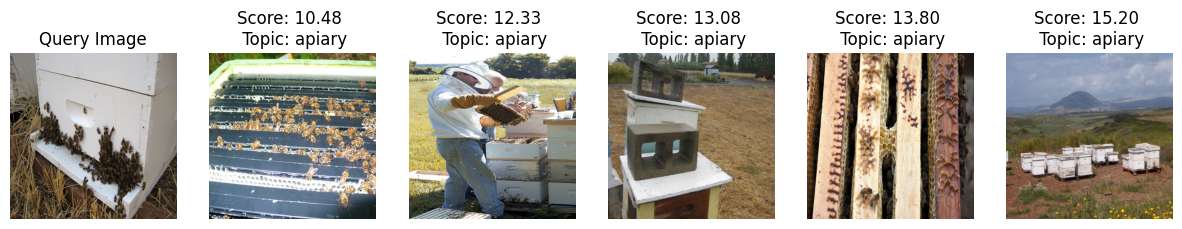

In [20]:
root_img_path = f"{ROOT}/train/"
query_path = "data/test/apiary/n02727426_4398.JPEG"
size = (448, 448)
query, ls_path_score = get_l1_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=False)

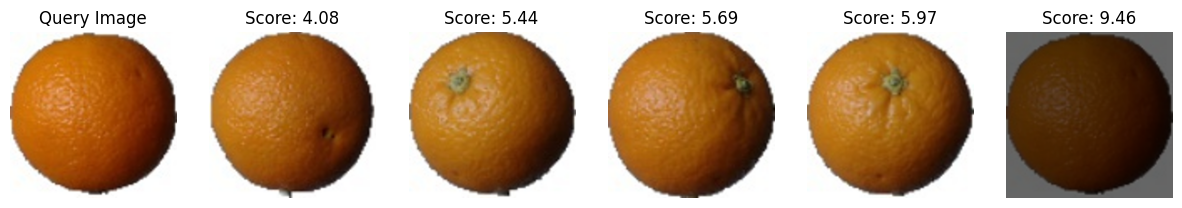

In [15]:
root_img_path = f"{ROOT}/train/"
query_path = "data/test/Orange_easy/0_100.jpg"
size = (448, 448)
query, ls_path_score = get_l1_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=False)

In [23]:
def mean_square_difference(query,data):
    axis_batch_size = tuple(range(1,len(data.shape)))
    return np.sqrt(np.sum((data-query)**2,axis = axis_batch_size))

In [24]:
def get_l2_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size)  # mảng numpy nhiều ảnh, paths

            embedding_list = []
            for idx_img in range(images_np.shape[0]):
                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)
            rates = mean_square_difference(query_embedding, np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score


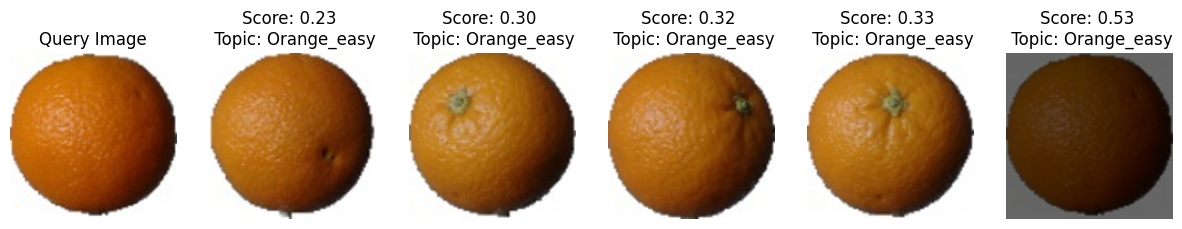

In [25]:
root_img_path = f"{ROOT}/train/"
query_path = "data/test/Orange_easy/0_100.jpg"
size = (448, 448)
query, ls_path_score = get_l2_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=False)

In [26]:
def cosine_similarity(query, data):
    axis_batch_size = tuple(range(1, len(data.shape)))
    query_norm = np.sqrt(np.sum(query**2))
    data_norm = np.sqrt(np.sum(data**2, axis=axis_batch_size))
    return np.sum(data * query, axis=axis_batch_size) / (query_norm * data_norm + np.finfo(float).eps)

In [28]:
def get_cosine_similarity_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    lquery_embedding = get_single_image_embedding(query)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size)  # mảng numpy nhiều ảnh, paths

            embedding_list = []
            for idx_img in range(images_np.shape[0]):
                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)
            rates = cosine_similarity(lquery_embedding, np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score

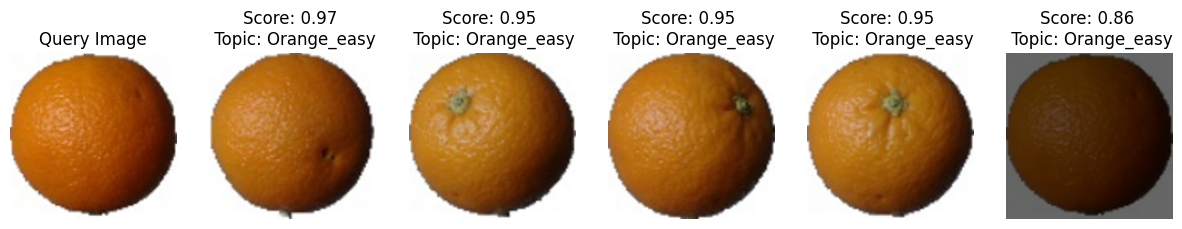

In [29]:
root_img_path = f"{ROOT}/train/"
query_path = "data/test/Orange_easy/0_100.jpg"
size = (448, 448)
query, ls_path_score = get_cosine_similarity_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=True)

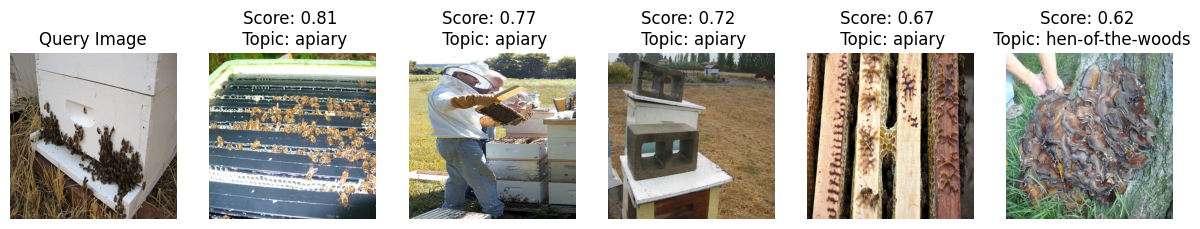

In [30]:
root_img_path = f"{ROOT}/train/"
query_path = "data/test/apiary/n02727426_4398.JPEG"
size = (448, 448)
query, ls_path_score = get_cosine_similarity_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=True)

In [32]:
def correlation_coefficient(query, data):
    axis_batch_size = tuple(range(1, len(data.shape)))
    query_mean = query - np.mean(query)
    data_mean = data - np.mean(data, axis=axis_batch_size, keepdims=True)
    query_norm = np.sqrt(np.sum(query_mean**2))
    data_norm = np.sqrt(np.sum(data_mean**2, axis=axis_batch_size))
    return np.sum(data_mean * query_mean, axis=axis_batch_size) / (query_norm * data_norm + np.finfo(float).eps)

In [33]:
def get_correlation_coefficient_score(root_img_path, query_path, size):
    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size)  # mảng numpy nhiều ảnh, paths

            embedding_list = []
            for idx_img in range(images_np.shape[0]):
                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)
            
            rates = correlation_coefficient(query_embedding, np.stack(embedding_list))
            ls_path_score.extend(list(zip(images_path, rates)))
    return query, ls_path_score


In [34]:
root_img_path = f"{ROOT}/train/"
query_path = "data/test/apiary/n02727426_4398.JPEG"
size = (448, 448)
query, ls_path_score = get_correlation_coefficient_score(root_img_path, query_path, size)
plot_results(query_path, ls_path_score, reverse=True)

ValueError: operands could not be broadcast together with shapes (10,448,448,3) (512,) 